# Run a Gene Ontology Enrichment Analysis (GOEA)
We use data from a 2014 Nature paper:    
[Computational analysis of cell-to-cell heterogeneity
in single-cell RNA-sequencing data reveals hidden 
subpopulations of cells
](http://www.nature.com/nbt/journal/v33/n2/full/nbt.3102.html#methods)

Note: you must have the Python package, **xlrd**, installed to run this example. 

Note: To create plots, you must have:
  * Python packages: **pyparsing**, **pydot**
  * [Graphviz](http://www.graphviz.org/) loaded and your PATH environmental variable pointing to the Graphviz bin directory.

## 1. Download Ontologies and Associations

### 1a. Download Ontologies, if necessary

In [1]:
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

  EXISTS: go-basic.obo


### 1b. Download Associations, if necessary
The NCBI gene2go file contains numerous species. We will select mouse shortly.

In [2]:
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations()

  EXISTS: gene2go


## 2. Load Ontologies, Associations and Background gene set 

### 2a. Load Ontologies

In [3]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2021-05-01) 47,284 GO Terms


### 2b. Load Associations

In [6]:
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:05.224880 335,071 annotations, 20,671 genes, 18,385 GOs, 1 taxids READ: gene2go 
BP 18,655 annotated human genes
MF 18,153 annotated human genes
CC 19,386 annotated human genes


In [5]:
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[10090])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:05.679535 384,668 annotations, 24,322 genes, 18,476 GOs, 1 taxids READ: gene2go 
BP 18,504 annotated mouse genes
MF 17,183 annotated mouse genes
CC 19,165 annotated mouse genes


### 2c. Load Background gene set
In this example, the background is all mouse protein-codinge genes.    

Follow the instructions in the `background_genes_ncbi` notebook to download a set of background population genes from NCBI.

In [7]:
from genes_ncbi_9606 import GENEID2NT as GeneID2nt_hs
print(len(GeneID2nt_hs))

ModuleNotFoundError: No module named 'genes_ncbi_9606_proteincoding'

In [8]:
from genes_ncbi_10090_proteincoding import GENEID2NT as GeneID2nt_mus
print(len(GeneID2nt_mus))

ModuleNotFoundError: No module named 'genes_ncbi_10090_proteincoding'

## 3. Initialize a GOEA object
The GOEA object holds the Ontologies, Associations, and background.    
Numerous studies can then be run withough needing to re-load the above items.    
In this case, we only run one GOEA.    

In [58]:
alleles = ['HLA-A03_01', 'HLA-B07_02', 'HLA-B35_03', 'HLA-C04_01', 'HLA-C07_02']
allele = alleles[4]

with open('../../neopeptide/all_geneID_HLA-B35_03.txt') as f:
    background = [int(f_.strip('\n')) for f_ in f.readlines()]
    
with open('../../neopeptide/nothighbinders_geneID_'+allele+'.txt') as f:
    gene_set = [int(f_.strip('\n')) for f_ in f.readlines()]


In [59]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        background, # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method



Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 88% 16,689 of 18,950 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93% 17,625 of 18,950 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 91% 17,151 of 18,950 population items found in association


## 5. Run Gene Ontology Enrichment Analysis (GOEA)
You may choose to keep all results or just the significant results. In this example, we choose to keep only the significant results.

In [60]:
# 'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.
goea_results_all = goeaobj.run_study(gene_set)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]


Run BP Gene Ontology Analysis: current study set of 2068 IDs ... 88%  1,816 of  2,068 study items found in association
100%  2,068 of  2,068 study items found in population(18950)
Calculating 12,152 uncorrected p-values using fisher_scipy_stats
  12,152 GO terms are associated with 16,689 of 18,950 population items
   4,855 GO terms are associated with  1,816 of  2,068 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.05=alpha) (  3 enriched +   3 purified): statsmodels fdr_bh
      41 study items associated with significant GO IDs (enriched)
     153 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2068 IDs ... 93%  1,922 of  2,068 study items found in association
100%  2,068 of  2,068 study items found in population(18950)
Calculating 1,745 uncorrected p-values using fisher_scipy_stats
   1,745 GO terms are associated with 17,625 of 18,950 population items
     933 GO terms are associated with  1,922 o

## 6. Write results to an Excel file and to a text file

In [61]:
goeaobj.wr_xlsx("GOE_"+allele+"_nothigh.xlsx", goea_results_sig)
goeaobj.wr_txt("GOE_"+allele+"_nothigh.txt", goea_results_sig)

     25 items WROTE: GOE_HLA-C07_02_nothigh.xlsx
     25 GOEA results for  1717 study items. WROTE: GOE_HLA-C07_02_nothigh.txt


## 7. Plot all significant GO terms
Plotting all significant GO terms produces a messy spaghetti plot. Such a plot can be useful sometimes because you can open it and zoom and scroll around. But sometimes it is just too messy to be of use.

The **"{NS}"** in **"nbt3102_{NS}.png"** indicates that you will see three plots, one for "biological_process"(BP), "molecular_function"(MF), and "cellular_component"(CC)

In [3]:
alleles = ['HLA-A03_01', 'HLA-B07_02', 'HLA-B35_03', 'HLA-C04_01', 'HLA-C07_02']

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
from fractions import Fraction

import matplotlib
from pylab import figure, cm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

matplotlib.rcParams['lines.markersize'] = 15

font = {'size'   : 16}
matplotlib.rc('font', **font)

In [21]:
combined_df = []

for it, allele in enumerate(alleles):

    f = "GOE_"+allele+"_nothigh.xlsx"

    read_df = pd.read_excel(f)
    read_df['allele'] = allele
    combined_df.append(read_df)

combined_df = pd.concat(combined_df)
combined_df = combined_df.sort_values('enrichment')
#combined_df = combined_df[combined_df['NS'] == 'MF']

/dfs/user/yhr/torch3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  import sys


In [22]:
allGO = []
allGO.extend(combined_df[combined_df['NS'] == 'MF']['name'].unique())
allGO.extend(combined_df[combined_df['NS'] == 'BP']['name'].unique())
allGO.extend(combined_df[combined_df['NS'] == 'CC']['name'].unique())

In [23]:
GO_map = {g:i for i,g in enumerate(allGO)}
allele_map = {a:i for i,a in enumerate(alleles)}
pe_map = {'p':'Depletion', 'e':'Enrichment'}

inv_GO_map = {v: k for k, v in GO_map.items()}

### Plot all GO terms from all alleles (Supplementary)

Text(0.5, 1.0, 'GO Term Enrichment for genes not predicted to have strong MHC binding')

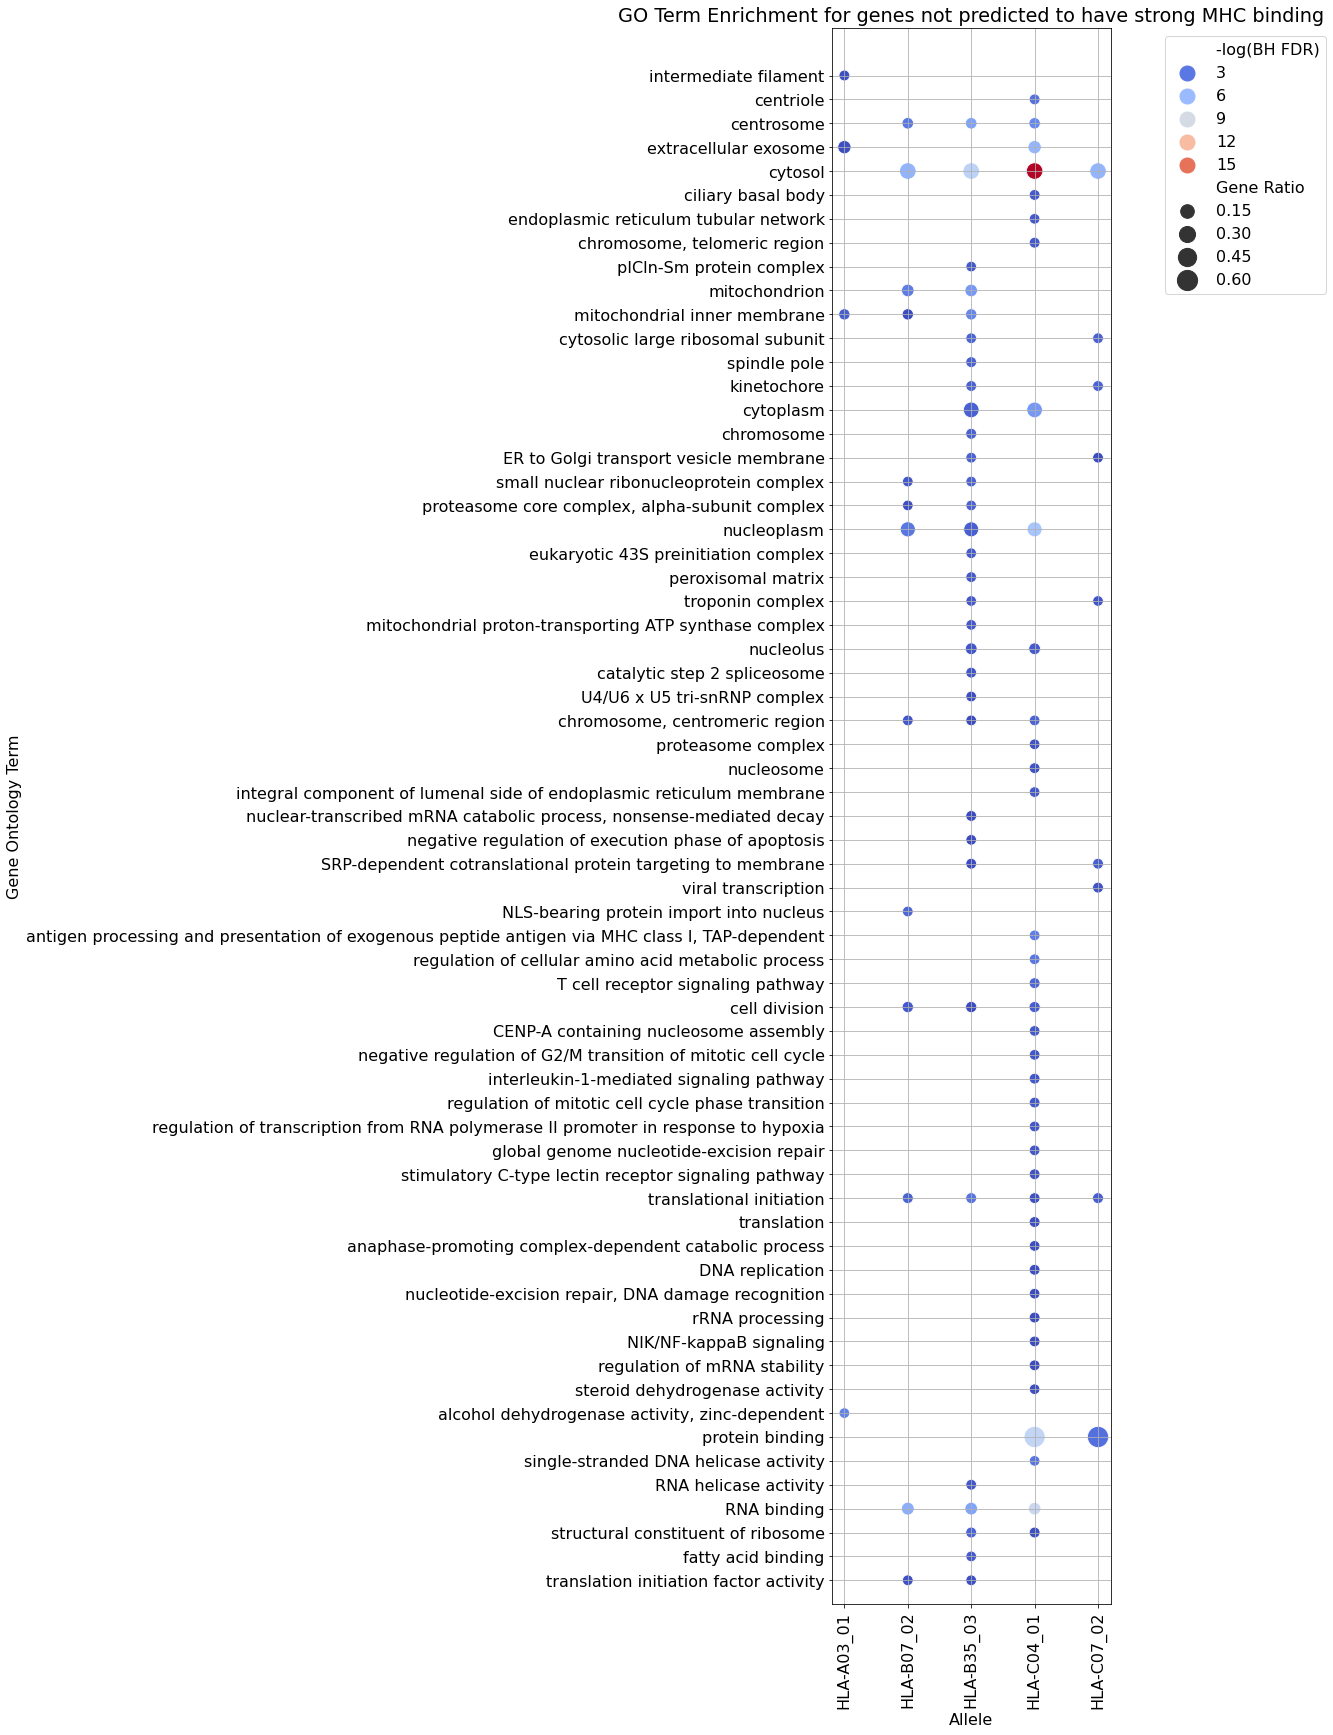

In [32]:
## Enrichment only plot all alleles

plot_df = pd.DataFrame()
plot_df['p_fdr_bh'] = combined_df['p_fdr_bh'].astype('float').values
plot_df['-log(BH FDR)'] = -plot_df['p_fdr_bh'].apply(np.log10)
plot_df['Type'] = combined_df['enrichment'].map(pe_map).values
plot_df['Gene Ratio'] = combined_df['ratio_in_study'].apply(Fraction).astype('float').values
plot_df['GO'] = combined_df['name'].map(GO_map).values
plot_df['allele'] = combined_df['allele'].map(allele_map).values

plot_df = plot_df[plot_df['Type']=='Enrichment']

#keep_terms = plot_df['GO'].value_counts()[plot_df['GO'].value_counts()>1].index.values
#plot_df = plot_df[plot_df['GO'].isin(keep_terms)]

GO_to_plot = np.sort(plot_df['GO'].unique())
key_map = {g:i for i,g in enumerate(GO_to_plot)}

fig = plt.figure(figsize=[5,int(len(key_map)/2.2)])
plt.grid()
plot_df['GO_map'] = plot_df['GO'].map(key_map)

ax = sns.scatterplot(data=plot_df,
               x='allele', y='GO_map',
               size='Gene Ratio', hue='-log(BH FDR)', 
               #hue_norm=(0,50), size_norm=(0.1,0.5),
                     palette='coolwarm')
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))



ax.set_xlabel('Allele')
ax.set_xticks(range(len(alleles)))
ax.set_yticks(range(len(GO_to_plot)))
ax.set_xticklabels(alleles, rotation=90)
ax.set_yticklabels([inv_GO_map[i] for i in GO_to_plot])
ax.set_ylabel('Gene Ontology Term')


ax.set_ylim([-1, len(key_map)+1])
plt.title('GO Term Enrichment for genes not predicted to have strong MHC binding')
#ax.legend_.remove()

Text(0.5, 1.0, 'GO Term Depletion for genes not predicted to have strong MHC binding')

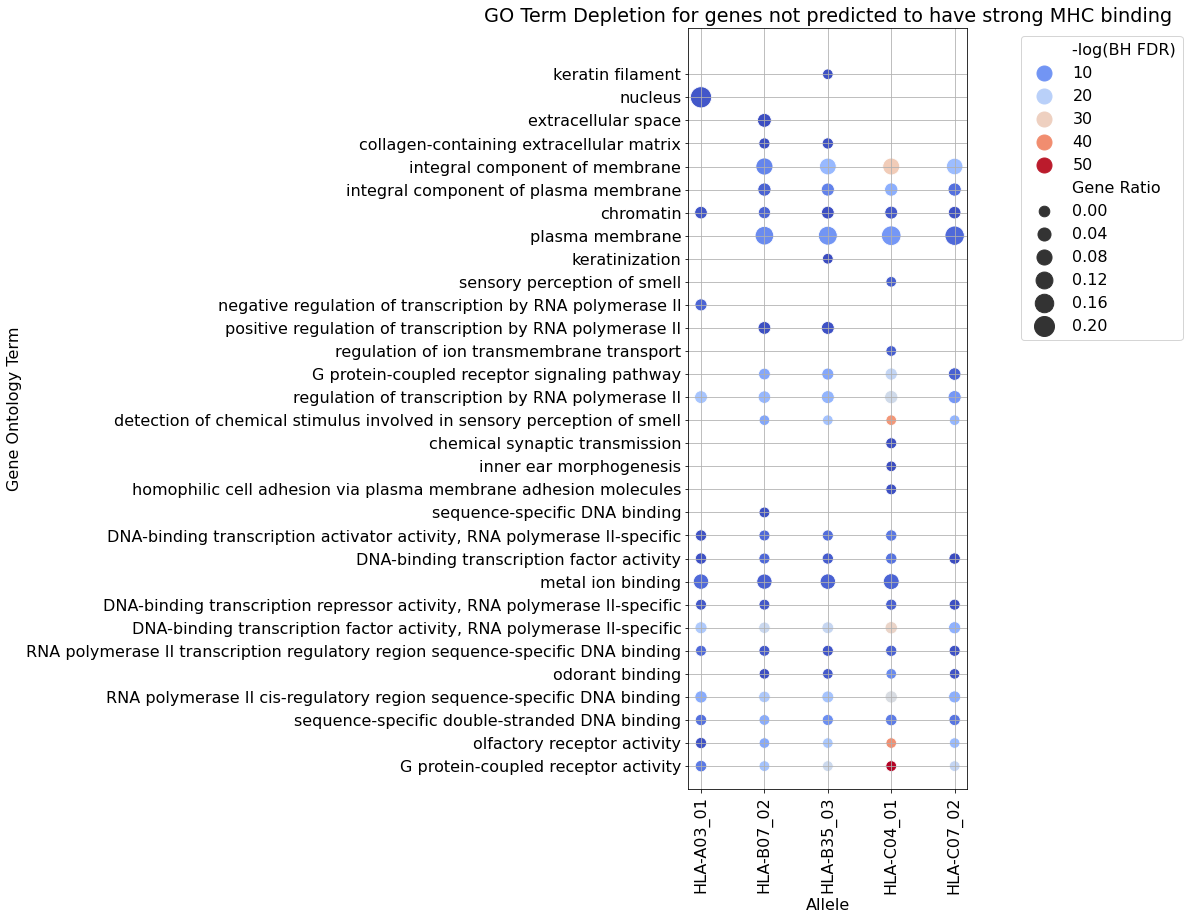

In [33]:
## Depletion only plot all alleles

plot_df = pd.DataFrame()
plot_df['p_fdr_bh'] = combined_df['p_fdr_bh'].astype('float').values
plot_df['-log(BH FDR)'] = -plot_df['p_fdr_bh'].apply(np.log10)
plot_df['Type'] = combined_df['enrichment'].map(pe_map).values
plot_df['Gene Ratio'] = combined_df['ratio_in_study'].apply(Fraction).astype('float').values
plot_df['GO'] = combined_df['name'].map(GO_map).values
plot_df['allele'] = combined_df['allele'].map(allele_map).values

plot_df = plot_df[plot_df['Type']=='Depletion']

#keep_terms = plot_df['GO'].value_counts()[plot_df['GO'].value_counts()>1].index.values
#plot_df = plot_df[plot_df['GO'].isin(keep_terms)]

GO_to_plot = np.sort(plot_df['GO'].unique())
key_map = {g:i for i,g in enumerate(GO_to_plot)}

fig = plt.figure(figsize=[5,int(len(key_map)/2.2)])
plt.grid()
plot_df['GO_map'] = plot_df['GO'].map(key_map)

ax = sns.scatterplot(data=plot_df,
               x='allele', y='GO_map',
               size='Gene Ratio', hue='-log(BH FDR)', 
               #hue_norm=(0,50), size_norm=(0.1,0.5),
                     palette='coolwarm')
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))



ax.set_xlabel('Allele')
ax.set_xticks(range(len(alleles)))
ax.set_yticks(range(len(GO_to_plot)))
ax.set_xticklabels(alleles, rotation=90)
ax.set_yticklabels([inv_GO_map[i] for i in GO_to_plot])
ax.set_ylabel('Gene Ontology Term')


ax.set_ylim([-1, len(key_map)+1])
plt.title('GO Term Depletion for genes not predicted to have strong MHC binding')
#ax.legend_.remove()

### Abridged - Consider only those GO terms that appear in at least two alleles

Text(0.5, 1.0, 'GO Term Enrichment for genes not predicted to have strong MHC binding')

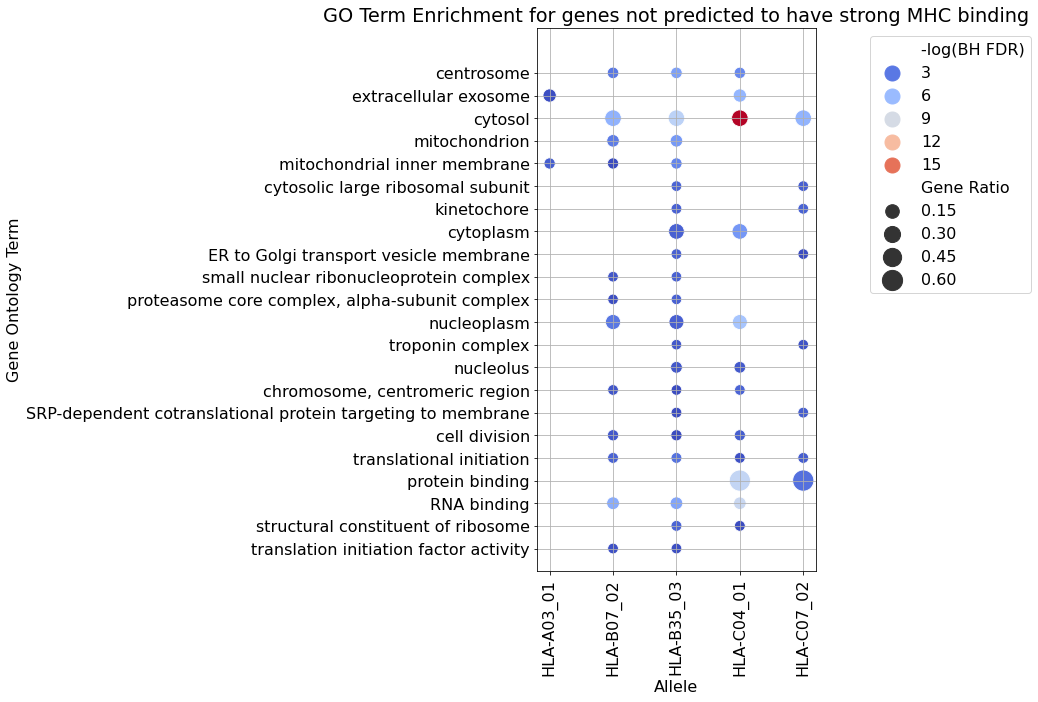

In [35]:
## Enrichment only plot

plot_df = pd.DataFrame()
plot_df['p_fdr_bh'] = combined_df['p_fdr_bh'].astype('float').values
plot_df['-log(BH FDR)'] = -plot_df['p_fdr_bh'].apply(np.log10)
plot_df['Type'] = combined_df['enrichment'].map(pe_map).values
plot_df['Gene Ratio'] = combined_df['ratio_in_study'].apply(Fraction).astype('float').values
plot_df['GO'] = combined_df['name'].map(GO_map).values
plot_df['allele'] = combined_df['allele'].map(allele_map).values

plot_df = plot_df[plot_df['Type']=='Enrichment']

keep_terms = plot_df['GO'].value_counts()[plot_df['GO'].value_counts()>1].index.values
plot_df = plot_df[plot_df['GO'].isin(keep_terms)]

GO_to_plot = np.sort(plot_df['GO'].unique())
key_map = {g:i for i,g in enumerate(GO_to_plot)}

fig = plt.figure(figsize=[5,int(len(key_map)/2.2)])
plt.grid()
plot_df['GO_map'] = plot_df['GO'].map(key_map)

ax = sns.scatterplot(data=plot_df,
               x='allele', y='GO_map',
               size='Gene Ratio', hue='-log(BH FDR)', 
               #hue_norm=(0,50), size_norm=(0.1,0.5),
                     palette='coolwarm')
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))



ax.set_xlabel('Allele')
ax.set_xticks(range(len(alleles)))
ax.set_yticks(range(len(GO_to_plot)))
ax.set_xticklabels(alleles, rotation=90)
ax.set_yticklabels([inv_GO_map[i] for i in GO_to_plot])
ax.set_ylabel('Gene Ontology Term')


ax.set_ylim([-1, len(key_map)+1])
plt.title('GO Term Enrichment for genes not predicted to have strong MHC binding')
#ax.legend_.remove()

Text(0.5, 1.0, 'GO Term Depletion for genes not predicted to have strong MHC binding')

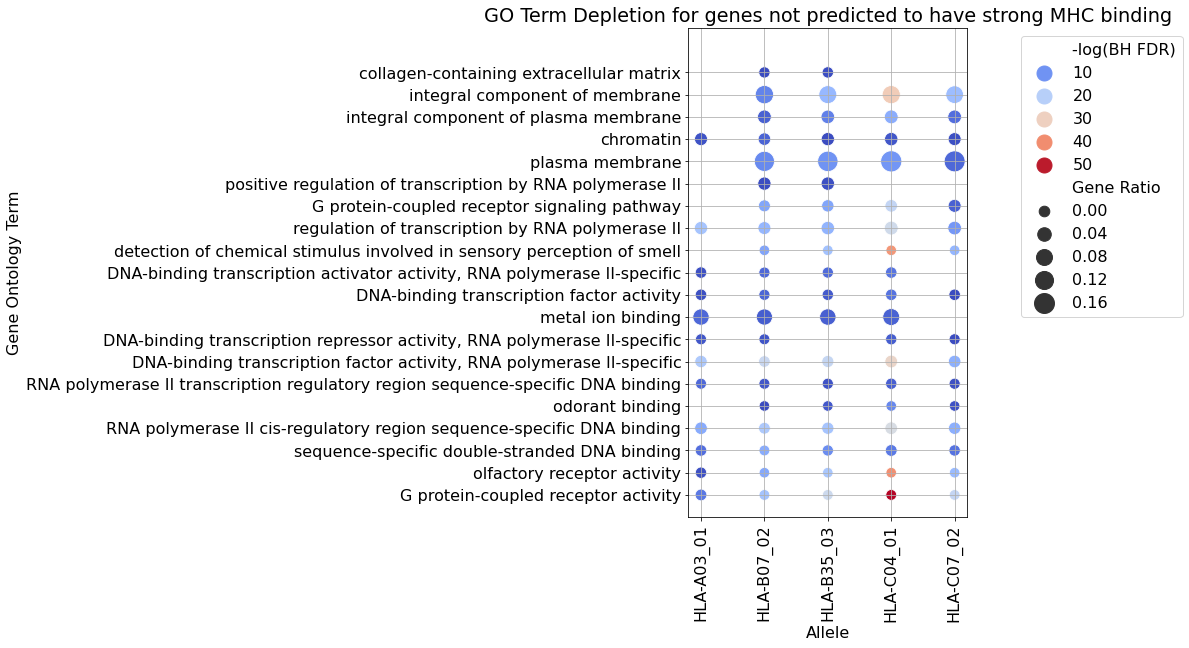

In [36]:
## Depletion only plot 

plot_df = pd.DataFrame()
plot_df['p_fdr_bh'] = combined_df['p_fdr_bh'].astype('float').values
plot_df['-log(BH FDR)'] = -plot_df['p_fdr_bh'].apply(np.log10)
plot_df['Type'] = combined_df['enrichment'].map(pe_map).values
plot_df['Gene Ratio'] = combined_df['ratio_in_study'].apply(Fraction).astype('float').values
plot_df['GO'] = combined_df['name'].map(GO_map).values
plot_df['allele'] = combined_df['allele'].map(allele_map).values

plot_df = plot_df[plot_df['Type']=='Depletion']

keep_terms = plot_df['GO'].value_counts()[plot_df['GO'].value_counts()>1].index.values
plot_df = plot_df[plot_df['GO'].isin(keep_terms)]

GO_to_plot = np.sort(plot_df['GO'].unique())
key_map = {g:i for i,g in enumerate(GO_to_plot)}

fig = plt.figure(figsize=[5,int(len(key_map)/2.2)])
plt.grid()
plot_df['GO_map'] = plot_df['GO'].map(key_map)

ax = sns.scatterplot(data=plot_df,
               x='allele', y='GO_map',
               size='Gene Ratio', hue='-log(BH FDR)', 
               #hue_norm=(0,50), size_norm=(0.1,0.5),
                     palette='coolwarm')
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))



ax.set_xlabel('Allele')
ax.set_xticks(range(len(alleles)))
ax.set_yticks(range(len(GO_to_plot)))
ax.set_xticklabels(alleles, rotation=90)
ax.set_yticklabels([inv_GO_map[i] for i in GO_to_plot])
ax.set_ylabel('Gene Ontology Term')


ax.set_ylim([-1, len(key_map)+1])
plt.title('GO Term Depletion for genes not predicted to have strong MHC binding')
#ax.legend_.remove()